# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Read the datasets

In [45]:
# path to the files
attacks_path = '../data/raw/attacks.anon.train.csv'
vectors_path = '../data/raw/vectors.anon.train.csv'

In [46]:
attack_df = pd.read_csv(attacks_path)
attack_df.head()

,Attack ID,Card,Victim IP,Port number,Attack code,Detect count,Significant flag,Packet speed,Data speed,Avg packet len,Avg source IP count,Start time,End time,Whitelist flag,Type
0,1,sga10gq0,IP_0001,4500,High volume traffic,1,0,55600,73,1383,6,2022-08-08T18:09:36,2022-08-08T18:09:37,0,Normal traffic
1,2,sga10gq0,IP_0002,4500,High volume traffic,1,0,63500,90,1506,1,2022-08-08T18:37:28,2022-08-08T18:37:28,0,Normal traffic
2,3,sga10gq0,IP_0003,1200,High volume traffic,2,0,62700,82,1399,1,2022-08-08T18:41:25,2022-08-08T18:41:26,0,Normal traffic
3,4,sga10gq0,IP_0002,4500,High volume traffic,1,0,59500,85,1486,1,2022-08-08T18:47:49,2022-08-08T18:47:50,0,Normal traffic
4,5,sga10gq0,IP_0004,12347,High volume traffic,2,1,78250,113,1518,1,2022-08-08T18:57:15,2022-08-08T18:58:11,0,Normal traffic


In [145]:
vector_df = pd.read_csv(vectors_path)
vector_df.head()

,Attack ID,Detect count,Card,Victim IP,Port number,Attack code,Significant flag,Packet speed,Data speed,Avg packet len,Source IP count,Time
0,1,1,sga10gq0,IP_0001,4500,High volume traffic,0,55600,73,1383,6,2022-08-08T18:09:36
1,2,1,sga10gq0,IP_0002,4500,High volume traffic,0,63500,90,1506,1,2022-08-08T18:37:28
2,3,1,sga10gq0,IP_0003,1200,High volume traffic,0,59700,79,1399,1,2022-08-08T18:41:25
3,3,2,sga10gq0,IP_0003,1200,High volume traffic,0,65700,86,1399,1,2022-08-08T18:41:26
4,4,1,sga10gq0,IP_0002,4500,High volume traffic,0,59500,85,1486,1,2022-08-08T18:47:49


# Preprocess the data

In [146]:
# add labels to the vectors df
vector_df = pd.merge(vector_df, attack_df[['Attack ID', 'Type']], on='Attack ID', how='left')
vector_df.head()

,Attack ID,Detect count,Card,Victim IP,Port number,Attack code,Significant flag,Packet speed,Data speed,Avg packet len,Source IP count,Time,Type
0,1,1,sga10gq0,IP_0001,4500,High volume traffic,0,55600,73,1383,6,2022-08-08T18:09:36,Normal traffic
1,2,1,sga10gq0,IP_0002,4500,High volume traffic,0,63500,90,1506,1,2022-08-08T18:37:28,Normal traffic
2,3,1,sga10gq0,IP_0003,1200,High volume traffic,0,59700,79,1399,1,2022-08-08T18:41:25,Normal traffic
3,3,2,sga10gq0,IP_0003,1200,High volume traffic,0,65700,86,1399,1,2022-08-08T18:41:26,Normal traffic
4,4,1,sga10gq0,IP_0002,4500,High volume traffic,0,59500,85,1486,1,2022-08-08T18:47:49,Normal traffic


In [147]:
# column types
vector_df.dtypes

Attack ID            int64
Detect count         int64
Card                object
Victim IP           object
Port number          int64
Attack code         object
Significant flag     int64
Packet speed         int64
Data speed           int64
Avg packet len       int64
Source IP count      int64
Time                object
Type                object
dtype: object

In [148]:
# one-hot-encode attack labels
# convert string to list
vector_df['attack code list'] = vector_df['Attack code'].apply(lambda x: x.replace(', ',',').split(','))
# Identify unique labels
unique_labels = set(label for sublist in vector_df['attack code list'] for label in sublist)

# create empty one-hot encoded columns
for label in unique_labels:
    vector_df[label] = 0

# iterate through rows and update one-hot encoded columns
for idx, row in vector_df.iterrows():
    labels = row['attack code list']
    for label in labels:
        vector_df.at[idx, label] = 1

# drop the original 'attack code list' column
vector_df.drop('attack code list', axis=1, inplace=True)

vector_df.head()

,Attack ID,Detect count,Card,Victim IP,Port number,Attack code,Significant flag,Packet speed,Data speed,Avg packet len,...,CHARGEN,RDP,High volume traffic,Sentinel,IPv4 fragmentation,Suspicious traffic,SSDP,TCP Anomaly,SNMP,DNS
0,1,1,sga10gq0,IP_0001,4500,High volume traffic,0,55600,73,1383,...,0,0,1,0,0,0,0,0,0,0
1,2,1,sga10gq0,IP_0002,4500,High volume traffic,0,63500,90,1506,...,0,0,1,0,0,0,0,0,0,0
2,3,1,sga10gq0,IP_0003,1200,High volume traffic,0,59700,79,1399,...,0,0,1,0,0,0,0,0,0,0
3,3,2,sga10gq0,IP_0003,1200,High volume traffic,0,65700,86,1399,...,0,0,1,0,0,0,0,0,0,0
4,4,1,sga10gq0,IP_0002,4500,High volume traffic,0,59500,85,1486,...,0,0,1,0,0,0,0,0,0,0


In [149]:
# ip address
vector_df['victim IP num'] = vector_df['Victim IP'].apply(lambda x: int(x.split('_')[1]))
vector_df['victim IP num']

0             1
1             2
2             3
3             3
4             2
          ...  
586637    17466
586638      157
586639      157
586640       10
586641       40
Name: victim IP num, Length: 586642, dtype: int64

In [150]:
# time column -> is_weekday, time_of_day
# convert date string to datetime
vector_df.rename(columns = {'Time':'time string'}, inplace = True)

# was the time on the weekend
vector_df['time'] = pd.to_datetime(vector_df['time string'])
vector_df['is_weekday'] = vector_df['time'].apply(lambda x: int(x.weekday() < 5))
vector_df['is_weekday']

# time of day in seconds
vector_df['time_of_day'] = vector_df['time'].dt.time
vector_df['time_of_day'] = vector_df['time_of_day'].apply(lambda x: 60*60*x.hour + 60*x.minute + x.second)
vector_df['time_of_day'] 

0         65376
1         67048
2         67285
3         67286
4         67669
          ...  
586637    45149
586638    45171
586639    45172
586640    45318
586641    45404
Name: time_of_day, Length: 586642, dtype: int64

In [151]:
vector_df.dtypes

Attack ID                       int64
Detect count                    int64
Card                           object
Victim IP                      object
Port number                     int64
Attack code                    object
Significant flag                int64
Packet speed                    int64
Data speed                      int64
Avg packet len                  int64
Source IP count                 int64
time string                    object
Type                           object
CLDAP                           int64
Generic UDP                     int64
CoAP                            int64
ACK Attack                      int64
NTP                             int64
SYN Attack                      int64
RPC                             int64
CHARGEN                         int64
RDP                             int64
High volume traffic             int64
Sentinel                        int64
IPv4 fragmentation              int64
Suspicious traffic              int64
SSDP        

In [152]:
# drop columns
cols_to_drop = ['Card', 'Attack ID', 'Detect count', 'Victim IP', 'Attack code', 'time string', 'time']

full_vector_df = vector_df.copy()
vector_df = full_vector_df.drop(cols_to_drop, axis=1)

print(len(vector_df.columns))
vector_df.dtypes

27


Port number             int64
Significant flag        int64
Packet speed            int64
Data speed              int64
Avg packet len          int64
Source IP count         int64
Type                   object
CLDAP                   int64
Generic UDP             int64
CoAP                    int64
ACK Attack              int64
NTP                     int64
SYN Attack              int64
RPC                     int64
CHARGEN                 int64
RDP                     int64
High volume traffic     int64
Sentinel                int64
IPv4 fragmentation      int64
Suspicious traffic      int64
SSDP                    int64
TCP Anomaly             int64
SNMP                    int64
DNS                     int64
victim IP num           int64
is_weekday              int64
time_of_day             int64
dtype: object

# Augmemtation

We are using the SMOTE algorithm

In [190]:
# Define numerical and target columns
numerical_cols = ['Port number', 'Packet speed', 'Data speed', 'Avg packet len', 'Source IP count', 'victim IP num', 'time_of_day']
target_col = 'Type'
non_numeric_cols = []
for col in vector_df.columns:
    if col not in numerical_cols:
        non_numeric_cols.append(col)
non_numeric_cols

['Significant flag',
 'Type',
 'CLDAP',
 'Generic UDP',
 'CoAP',
 'ACK Attack',
 'NTP',
 'SYN Attack',
 'RPC',
 'CHARGEN',
 'RDP',
 'High volume traffic',
 'Sentinel',
 'IPv4 fragmentation',
 'Suspicious traffic',
 'SSDP',
 'TCP Anomaly',
 'SNMP',
 'DNS',
 'is_weekday']

In [191]:
# Define preprocessing steps for numerical columns
numerical_transformer = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_cols)
], remainder='passthrough')

In [192]:
vector_df.iloc[0]

Port number                      4500
Significant flag                    0
Packet speed                    55600
Data speed                         73
Avg packet len                   1383
Source IP count                     6
Type                   Normal traffic
CLDAP                               0
Generic UDP                         0
CoAP                                0
ACK Attack                          0
NTP                                 0
SYN Attack                          0
RPC                                 0
CHARGEN                             0
RDP                                 0
High volume traffic                 1
Sentinel                            0
IPv4 fragmentation                  0
Suspicious traffic                  0
SSDP                                0
TCP Anomaly                         0
SNMP                                0
DNS                                 0
victim IP num                       1
is_weekday                          1
time_of_day 

In [195]:
# fit the scaler
df_scaled = preprocessor.fit_transform(vector_df)

# Convert the result back to a DataFrame
df_scaled = pd.DataFrame(df_scaled, columns = numerical_cols + non_numeric_cols)
df_scaled.head()

,Port number,Packet speed,Data speed,Avg packet len,Source IP count,victim IP num,time_of_day,Significant flag,Type,CLDAP,...,RDP,High volume traffic,Sentinel,IPv4 fragmentation,Suspicious traffic,SSDP,TCP Anomaly,SNMP,DNS,is_weekday
0,-0.797923,-0.27777,-0.170063,0.71887,-0.119381,-0.586344,0.585269,0,Normal traffic,0,...,0,1,0,0,0,0,0,0,0,1
1,-0.797923,-0.183982,0.03276,0.93549,-0.138697,-0.586157,0.655756,0,Normal traffic,0,...,0,1,0,0,0,0,0,0,0,1
2,-0.925953,-0.229095,-0.098479,0.747049,-0.138697,-0.58597,0.665747,0,Normal traffic,0,...,0,1,0,0,0,0,0,0,0,1
3,-0.925953,-0.157864,-0.014963,0.747049,-0.138697,-0.58597,0.665789,0,Normal traffic,0,...,0,1,0,0,0,0,0,0,0,1
4,-0.797923,-0.231469,-0.026894,0.900267,-0.138697,-0.586157,0.681935,0,Normal traffic,0,...,0,1,0,0,0,0,0,0,0,1


In [196]:
# drop the target column
df_scaled = df_scaled.drop('Type', axis=1)
df_scaled.columns

Index(['Port number', 'Packet speed', 'Data speed', 'Avg packet len',
       'Source IP count', 'victim IP num', 'time_of_day', 'Significant flag',
       'CLDAP', 'Generic UDP', 'CoAP', 'ACK Attack', 'NTP', 'SYN Attack',
       'RPC', 'CHARGEN', 'RDP', 'High volume traffic', 'Sentinel',
       'IPv4 fragmentation', 'Suspicious traffic', 'SSDP', 'TCP Anomaly',
       'SNMP', 'DNS', 'is_weekday'],
      dtype='object')

In [197]:
df_scaled.dtypes

Port number            object
Packet speed           object
Data speed             object
Avg packet len         object
Source IP count        object
victim IP num          object
time_of_day            object
Significant flag       object
CLDAP                  object
Generic UDP            object
CoAP                   object
ACK Attack             object
NTP                    object
SYN Attack             object
RPC                    object
CHARGEN                object
RDP                    object
High volume traffic    object
Sentinel               object
IPv4 fragmentation     object
Suspicious traffic     object
SSDP                   object
TCP Anomaly            object
SNMP                   object
DNS                    object
is_weekday             object
dtype: object

In [198]:
for col in numerical_cols:
    df_scaled[col] = df_scaled[col].astype("float64")

for col in non_numeric_cols:
    if col != 'Type':
        df_scaled[col] = df_scaled[col].astype("int32")

In [199]:
df_scaled.dtypes

Port number            float64
Packet speed           float64
Data speed             float64
Avg packet len         float64
Source IP count        float64
victim IP num          float64
time_of_day            float64
Significant flag         int32
CLDAP                    int32
Generic UDP              int32
CoAP                     int32
ACK Attack               int32
NTP                      int32
SYN Attack               int32
RPC                      int32
CHARGEN                  int32
RDP                      int32
High volume traffic      int32
Sentinel                 int32
IPv4 fragmentation       int32
Suspicious traffic       int32
SSDP                     int32
TCP Anomaly              int32
SNMP                     int32
DNS                      int32
is_weekday               int32
dtype: object

In [200]:
df_scaled.head()

,Port number,Packet speed,Data speed,Avg packet len,Source IP count,victim IP num,time_of_day,Significant flag,CLDAP,Generic UDP,...,RDP,High volume traffic,Sentinel,IPv4 fragmentation,Suspicious traffic,SSDP,TCP Anomaly,SNMP,DNS,is_weekday
0,-0.797923,-0.277770,-0.170063,0.718870,-0.119381,-0.586344,0.585269,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,-0.797923,-0.183982,0.032760,0.935490,-0.138697,-0.586157,0.655756,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,-0.925953,-0.229095,-0.098479,0.747049,-0.138697,-0.585970,0.665747,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,-0.925953,-0.157864,-0.014963,0.747049,-0.138697,-0.585970,0.665789,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,-0.797923,-0.231469,-0.026894,0.900267,-0.138697,-0.586157,0.681935,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [201]:
# Apply SMOTE to the combined features and target
smote = SMOTE(sampling_strategy='not majority', k_neighbors=20, random_state=42)
X_resampled, y_resampled = smote.fit_resample(df_scaled, vector_df[target_col])

# Transform augmented data

In [207]:
# Reshape the synthetic samples back into the original shape of the array column
synthetic_df = pd.DataFrame(X_resampled, columns=df_scaled.columns)
synthetic_df[target_col] = y_resampled
synthetic_df.head()

,Port number,Packet speed,Data speed,Avg packet len,Source IP count,victim IP num,time_of_day,Significant flag,CLDAP,Generic UDP,...,High volume traffic,Sentinel,IPv4 fragmentation,Suspicious traffic,SSDP,TCP Anomaly,SNMP,DNS,is_weekday,Type
0,-0.797923,-0.277770,-0.170063,0.718870,-0.119381,-0.586344,0.585269,0,0,0,...,1,0,0,0,0,0,0,0,1,Normal traffic
1,-0.797923,-0.183982,0.032760,0.935490,-0.138697,-0.586157,0.655756,0,0,0,...,1,0,0,0,0,0,0,0,1,Normal traffic
2,-0.925953,-0.229095,-0.098479,0.747049,-0.138697,-0.585970,0.665747,0,0,0,...,1,0,0,0,0,0,0,0,1,Normal traffic
3,-0.925953,-0.157864,-0.014963,0.747049,-0.138697,-0.585970,0.665789,0,0,0,...,1,0,0,0,0,0,0,0,1,Normal traffic
4,-0.797923,-0.231469,-0.026894,0.900267,-0.138697,-0.586157,0.681935,0,0,0,...,1,0,0,0,0,0,0,0,1,Normal traffic


In [208]:
# Create a new StandardScaler instance and fit it on the original data
scaler = StandardScaler()
scaler.fit(vector_df[numerical_cols])

# Inverse transform the numerical columns
final_numerical_cols = scaler.inverse_transform(synthetic_df[numerical_cols])

# Replace the transformed numerical columns with the original values
synthetic_df[numerical_cols] = final_numerical_cols

synthetic_df.head()

,Port number,Packet speed,Data speed,Avg packet len,Source IP count,victim IP num,time_of_day,Significant flag,CLDAP,Generic UDP,...,High volume traffic,Sentinel,IPv4 fragmentation,Suspicious traffic,SSDP,TCP Anomaly,SNMP,DNS,is_weekday,Type
0,4500.0,55600.0,73.0,1383.0,6.0,1.0,65376.0,0,0,0,...,1,0,0,0,0,0,0,0,1,Normal traffic
1,4500.0,63500.0,90.0,1506.0,1.0,2.0,67048.0,0,0,0,...,1,0,0,0,0,0,0,0,1,Normal traffic
2,1200.0,59700.0,79.0,1399.0,1.0,3.0,67285.0,0,0,0,...,1,0,0,0,0,0,0,0,1,Normal traffic
3,1200.0,65700.0,86.0,1399.0,1.0,3.0,67286.0,0,0,0,...,1,0,0,0,0,0,0,0,1,Normal traffic
4,4500.0,59500.0,85.0,1486.0,1.0,2.0,67669.0,0,0,0,...,1,0,0,0,0,0,0,0,1,Normal traffic


In [209]:
# convert columns
# round numericals
for col in numerical_cols:
  synthetic_df[col] = synthetic_df[col].apply(lambda x: int(np.round(x)))
synthetic_df.head()

,Port number,Packet speed,Data speed,Avg packet len,Source IP count,victim IP num,time_of_day,Significant flag,CLDAP,Generic UDP,...,High volume traffic,Sentinel,IPv4 fragmentation,Suspicious traffic,SSDP,TCP Anomaly,SNMP,DNS,is_weekday,Type
0,4500,55600,73,1383,6,1,65376,0,0,0,...,1,0,0,0,0,0,0,0,1,Normal traffic
1,4500,63500,90,1506,1,2,67048,0,0,0,...,1,0,0,0,0,0,0,0,1,Normal traffic
2,1200,59700,79,1399,1,3,67285,0,0,0,...,1,0,0,0,0,0,0,0,1,Normal traffic
3,1200,65700,86,1399,1,3,67286,0,0,0,...,1,0,0,0,0,0,0,0,1,Normal traffic
4,4500,59500,85,1486,1,2,67669,0,0,0,...,1,0,0,0,0,0,0,0,1,Normal traffic


In [224]:
# add synthetic label to new datapoints
synthetic_df['is_synthetic'] = synthetic_df.index >= vector_df.shape[0]
synthetic_df[synthetic_df['is_synthetic'] == True]

,Port number,Packet speed,Data speed,Avg packet len,Source IP count,victim IP num,time_of_day,Significant flag,CLDAP,Generic UDP,...,Sentinel,IPv4 fragmentation,Suspicious traffic,SSDP,TCP Anomaly,SNMP,DNS,is_weekday,Type,is_synthetic
586642,51413,85701,6,66,5,202,49744,0,0,0,...,0,0,1,0,0,0,0,1,DDoS attack,True
586643,443,409427,411,1058,159,7920,68944,1,1,0,...,0,0,1,0,0,0,0,1,DDoS attack,True
586644,51413,96009,6,66,4,202,53793,0,0,0,...,0,0,1,0,0,0,0,1,DDoS attack,True
586645,80,449118,566,1340,1502,8214,72109,1,0,0,...,0,0,1,0,0,0,1,1,DDoS attack,True
586646,51413,80783,13,198,16,202,17625,0,0,0,...,0,0,1,0,0,0,0,1,DDoS attack,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1346824,49261,64787,90,1465,4,151,1768,0,0,0,...,0,0,0,0,0,0,0,0,Suspicious traffic,True
1346825,57030,72145,86,1275,9,26,46546,0,0,0,...,0,0,1,0,0,0,0,1,Suspicious traffic,True
1346826,54345,78320,93,1256,12,40,36094,0,0,0,...,0,0,1,0,0,0,0,1,Suspicious traffic,True
1346827,51413,79996,5,66,3,202,29321,0,0,0,...,0,0,1,0,0,0,0,1,Suspicious traffic,True


In [225]:
# save the augmented data
synthetic_df.to_csv('../data/preprocessed/synthetic_vectors.csv', index = False)

# Analyse new dataset

In [226]:
vector_df = synthetic_df

Type
Normal traffic        448943
Suspicious traffic    448943
DDoS attack           448943
Name: count, dtype: int64


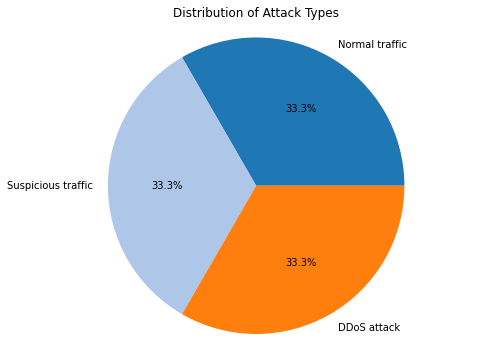

In [227]:
# see how many records are in different classes
value_counts = vector_df['Type'].value_counts()
labels = sorted(value_counts.index)
print(value_counts)

# Plot
plt.figure(figsize=(8, 6))
plt.pie(value_counts.values, labels = value_counts.index,  autopct='%1.1f%%', colors = plt.cm.tab20.colors)
plt.axis('equal')
plt.title("Distribution of Attack Types")

plt.savefig('../imgs/all_vector_df_type_dist.jpg', bbox_inches='tight')

plt.show()


Type
Suspicious traffic    390308
DDoS attack           369879
Name: count, dtype: int64


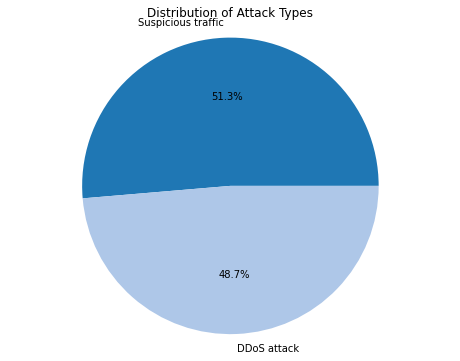

In [229]:
# see how many records are in different classes in the synthetic data
value_counts = vector_df[vector_df['is_synthetic'] == True]['Type'].value_counts()
labels = sorted(value_counts.index)
print(value_counts)

# Plot
plt.figure(figsize=(8, 6))
plt.pie(value_counts.values, labels = value_counts.index,  autopct='%1.1f%%', colors = plt.cm.tab20.colors)
plt.axis('equal')
plt.title("Distribution of Attack Types")

plt.savefig('../imgs/aug_vector_df_type_dist.jpg', bbox_inches='tight')

plt.show()

In [230]:
# import functions
from visualise import calculate_zscores, create_violin_plots

c:\bme\2. félév\adatlab\adaml_24\src\visualise.py:92: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_handles = [plt.Rectangle((0,0), 1, 1, color=color, edgecolor='black') for color in colors]


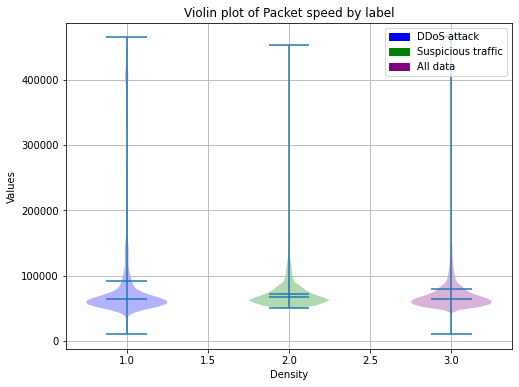

c:\bme\2. félév\adatlab\adaml_24\src\visualise.py:92: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_handles = [plt.Rectangle((0,0), 1, 1, color=color, edgecolor='black') for color in colors]


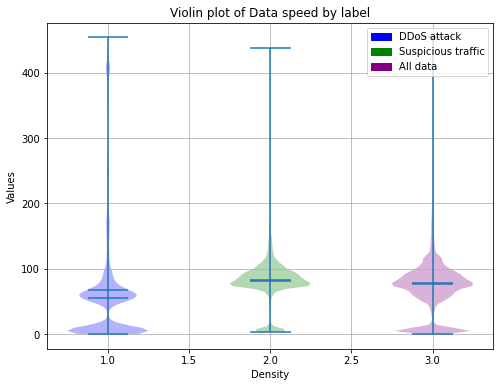

c:\bme\2. félév\adatlab\adaml_24\src\visualise.py:92: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_handles = [plt.Rectangle((0,0), 1, 1, color=color, edgecolor='black') for color in colors]


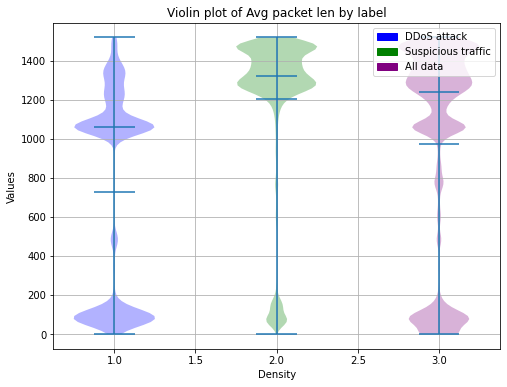

c:\bme\2. félév\adatlab\adaml_24\src\visualise.py:92: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_handles = [plt.Rectangle((0,0), 1, 1, color=color, edgecolor='black') for color in colors]


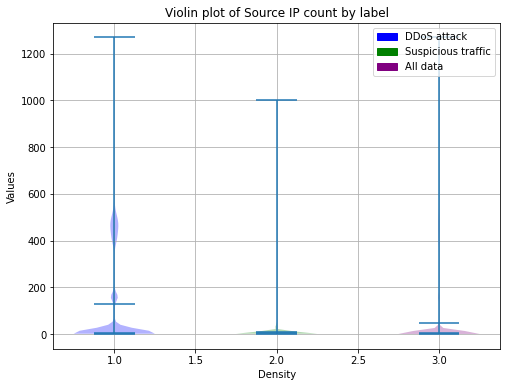

In [231]:
columns_to_plot = ['Packet speed', 'Data speed', 'Avg packet len', 'Source IP count']

for col in columns_to_plot:
  zscores = calculate_zscores(vector_df, col)
  create_violin_plots(vector_df, col, zscores, threshold = 3, labels= labels)

c:\bme\2. félév\adatlab\adaml_24\src\visualise.py:92: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_handles = [plt.Rectangle((0,0), 1, 1, color=color, edgecolor='black') for color in colors]


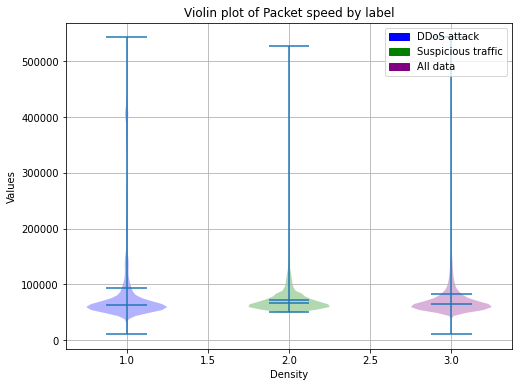

c:\bme\2. félév\adatlab\adaml_24\src\visualise.py:92: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_handles = [plt.Rectangle((0,0), 1, 1, color=color, edgecolor='black') for color in colors]


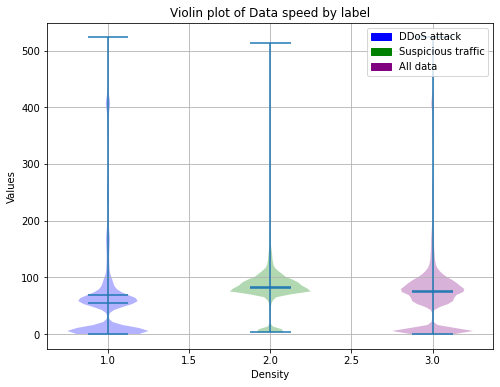

c:\bme\2. félév\adatlab\adaml_24\src\visualise.py:92: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_handles = [plt.Rectangle((0,0), 1, 1, color=color, edgecolor='black') for color in colors]


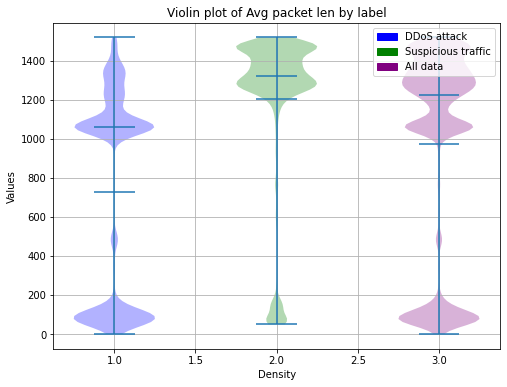

c:\bme\2. félév\adatlab\adaml_24\src\visualise.py:92: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_handles = [plt.Rectangle((0,0), 1, 1, color=color, edgecolor='black') for color in colors]


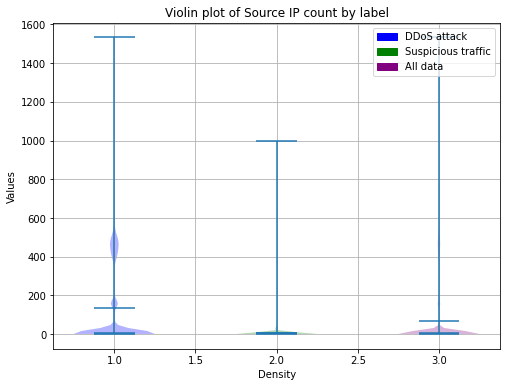

In [233]:
columns_to_plot = ['Packet speed', 'Data speed', 'Avg packet len', 'Source IP count']

for col in columns_to_plot:
  zscores = calculate_zscores(vector_df[vector_df['is_synthetic'] == True], col)
  create_violin_plots(vector_df[vector_df['is_synthetic'] == True], col, zscores, threshold = 3, labels=labels, synth = True)

# Preprocess the datasets

In [253]:
from dataloading import preprocess, standard_scale

In [264]:
# columns
attack_columns = ['Attack ID', 'Card', 'Victim IP', 'Port number', 'Attack code', 'Detect count', 'Significant flag',
                   'Packet speed', 'Data speed', 'Avg packet len', 'Avg source IP count', 'Start time', 'End time', 'Whitelist flag', 'Type']
vector_columns = ['Attack ID', 'Detect count', 'Card', 'Victim IP', 'Port number', 'Attack code', 'Significant flag', 
                  'Packet speed', 'Data speed', 'Avg packet len', 'Source IP count', 'Time']

numerical_cols = ['Port number', 'Packet speed', 'Data speed', 'Avg packet len', 'Source IP count', 'victim IP num', 'time_of_day']

## Train dataset

In [265]:
train_df = pd.read_csv('../data/preprocessed/train_vectors.csv')

# scale the numerical columns
scaled_df = standard_scale(train_df, numerical_cols)
scaled_df.head()

,Port number,Packet speed,Data speed,Avg packet len,Source IP count,victim IP num,time_of_day,Significant flag,CLDAP,Generic UDP,...,Sentinel,IPv4 fragmentation,Suspicious traffic,SSDP,TCP Anomaly,SNMP,DNS,is_weekday,Type,is_synthetic
0,-0.817317,-0.258647,-0.114203,0.752471,-0.179160,-0.604654,0.597073,0,0,0,...,0,0,0,0,0,0,0,1,Normal traffic,False
1,-0.817317,-0.195674,0.024471,0.978049,-0.191742,-0.604474,0.670414,0,0,0,...,0,0,0,0,0,0,0,1,Normal traffic,False
2,-0.941431,-0.225965,-0.065259,0.781814,-0.191742,-0.604294,0.680810,0,0,0,...,0,0,0,0,0,0,0,1,Normal traffic,False
3,-0.941431,-0.178138,-0.008159,0.781814,-0.191742,-0.604294,0.680854,0,0,0,...,0,0,0,0,0,0,0,1,Normal traffic,False
4,-0.817317,-0.227559,-0.016316,0.941370,-0.191742,-0.604474,0.697654,0,0,0,...,0,0,0,0,0,0,0,1,Normal traffic,False


In [266]:
# save the dataset
scaled_df.to_csv('../data/preprocessed/train_vectors_scaled.csv', index = False)

## Validation dataset

In [267]:
# path to the files
attacks_path = '../data/raw/attacks.anon.validation.csv'
vectors_path = '../data/raw/vectors.anon.validation.csv'

# read the datasets
attack_df = pd.read_csv(attacks_path, names = attack_columns)
vector_df = pd.read_csv(vectors_path, names= vector_columns)

#preprocess
preprocessed_df = preprocess(vector_df, attack_df)

In [268]:
# save the dataset
preprocessed_df.to_csv('../data/preprocessed/validation_vectors.csv', index = False)

In [269]:
# scale the numerical columns
scaled_df = standard_scale(preprocessed_df, numerical_cols)
scaled_df.head()

,Port number,Significant flag,Packet speed,Data speed,Avg packet len,Source IP count,Type,CLDAP,CoAP,RPC,...,CHARGEN,High volume traffic,SNMP,ICMP,Suspicious traffic,WSD,DNS,victim IP num,is_weekday,time_of_day
0,-0.497332,0,-0.241869,-0.168981,0.721867,-0.083648,Normal traffic,0,0,0,...,0,1,0,0,0,0,0,0.162923,1,0.793315
1,-0.497332,0,-0.160997,-0.078434,0.467209,-0.083648,Normal traffic,0,0,0,...,0,1,0,0,0,0,0,0.698114,1,0.794757
2,-0.497332,0,-0.232384,-0.158329,0.691907,-0.083648,Normal traffic,0,0,0,...,0,1,0,0,0,0,0,0.162923,1,0.795128
3,-0.497332,0,-0.093105,-0.030498,0.175101,-0.083648,Normal traffic,0,0,0,...,0,1,0,0,0,0,0,0.197020,1,0.795251
4,3.653735,0,-0.209920,-0.184960,0.160121,-0.083648,Normal traffic,0,0,0,...,0,1,0,0,0,0,0,0.197020,1,0.795251


In [270]:
# save the dataset
scaled_df.to_csv('../data/preprocessed/validation_vectors_scaled.csv', index = False)

## Test dataset

In [271]:
# path to the files
attacks_path = '../data/raw/attacks.anon.test.csv'
vectors_path = '../data/raw/vectors.anon.test.csv'

In [272]:
# read the datasets
attack_df = pd.read_csv(attacks_path, names = attack_columns)
vector_df = pd.read_csv(vectors_path, names= vector_columns)

#preprocess
preprocessed_df = preprocess(vector_df, attack_df)

In [273]:
# save the dataset
preprocessed_df.to_csv('../data/preprocessed/test_vectors.csv', index = False)

In [274]:
# scale the numerical columns
scaled_df = standard_scale(preprocessed_df, numerical_cols)
scaled_df.head()

,Port number,Significant flag,Packet speed,Data speed,Avg packet len,Source IP count,Type,ICMP,CLDAP,Generic UDP,...,High volume traffic,IPv4 fragmentation,Suspicious traffic,SSDP,TCP Anomaly,WSD,DNS,victim IP num,is_weekday,time_of_day
0,2.995883,0,-0.057031,-0.047010,-0.256544,-0.109514,Normal traffic,0,0,0,...,1,0,0,0,0,0,0,-1.006270,1,0.033073
1,-0.439311,0,-0.123416,-0.199993,-1.039122,-0.108497,Normal traffic,0,0,0,...,1,0,0,0,0,0,0,0.820936,1,0.033767
2,3.374160,0,-0.137710,-0.167786,-0.193092,-0.108497,Normal traffic,0,0,0,...,1,0,0,0,0,0,0,-3.612708,1,0.036372
3,-0.468309,0,-0.158356,-0.433495,-4.744031,-0.058646,Suspicious traffic,1,0,0,...,0,0,0,0,0,0,0,-3.428700,1,0.037327
4,0.957087,0,-0.092288,-0.107398,-0.295321,-0.104427,Normal traffic,0,0,0,...,1,0,0,0,0,0,0,-5.405045,1,0.037717


In [275]:
# save the dataset
scaled_df.to_csv('../data/preprocessed/test_vectors_scaled.csv', index = False)

## Generalisation dataset

In [283]:
# path to the files
attacks_path = '../data/raw/attacks.anon.gen.csv'
vectors_path = '../data/raw/vectors.anon.gen.csv'

# read the datasets
attack_df = pd.read_csv(attacks_path, header=0)
vector_df = pd.read_csv(vectors_path, header=0)

#preprocess
preprocessed_df = preprocess(vector_df, attack_df)

In [ ]:
# save the dataset
preprocessed_df.to_csv('../data/preprocessed/generalisation_vectors.csv', index = False)

In [ ]:
# scale the numerical columns
scaled_df = standard_scale(preprocessed_df, numerical_cols)
scaled_df.head()

In [ ]:
# save the dataset
scaled_df.to_csv('../data/preprocessed/generalisation_vectors_scaled.csv', index = False)